In [13]:
import numpy
import time
from utilities import select_gpus, plot_results # utilities.py: Contains a few miscellaneous functions 
from tcnae import TCNAE # tcnae.py: Specification of the TCN-AE model
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import urllib.request
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
import json
from WindowGen import WindowGenerator


%matplotlib inline
class TSdataset:

    def __init__(self, path:str, source:str):
        self.source = source
        self._features = {}
        self.MinMaxs = MinMaxScaler()
        if source =="NAB":
            split_name = str(path).split('/')
            self.ds_name = '/'.join(split_name[-2:])
            self.df = pd.read_csv(path, parse_dates=[0], index_col= 0)
            self.ts = np.array(self.df.value)
            self._features['DS_name']  = self.ds_name
            self._get_NAB_anomaly()


        elif source == "UCR":
            split_name = str(path).split('/')
            self.ds_name = '/'.join(split_name[-2:])
            split_name = str(split_name[-1]).split('.')[0]
            name_aux = str(split_name).split('_')
            self.ds_name = f"{split_name[-1]}"
            self.ts = np.genfromtxt(path)
            self.df = pd.DataFrame(self.ts, columns = ['value'])
            self._features['DS_name'] = self.ds_name
            anomaly = np.zeros(len(self.df), dtype = np.int)
            anomaly[int(name_aux[5]):int(name_aux[6])] = 1
            self.df['is_anomaly'] = anomaly


        elif source == "YAHOO":
            split_name = str(path).split('/')
            self.ds_name = '/'.join(split_name[-2:])
            self.df = pd.read_csv(path)
            self.df.set_index('timestamp', inplace = True)
            self.ts = np.array(self.df['value'])
            self._features['DS_name'] = self.ds_name
            
        self.ts_scaled = self.MinMaxs.fit_transform(self.ts.reshape(-1, 1))


    def _get_NAB_anomaly(self, path:str = None):
        if path == None:
            with urllib.request.urlopen("https://raw.githubusercontent.com/numenta/NAB/master/labels/combined_windows.json") as url:
                an = json.load(url)
        else:
            with open(path, "r") as jsonF:
                an = json.load(jsonF)

        aux = np.zeros(len(self.df), dtype = np.int)
        for start, end in an[self.ds_name]:
            aux[self.df.index.get_loc(pd.to_datetime(start)): self.df.index.get_loc(pd.to_datetime(end))] = 1
        self.df['is_anomaly'] = aux



    def _get_anomaly_window(self):
        edges = np.diff(np.concatenate([[0],self.df['is_anomaly'],[0]])).nonzero()[0]
        edges = edges.reshape((-1,2)) + np.array([0,-1])
        if self.source == 'NAB':
            return np.array(self.df.index)[edges]
        else:
            return edges


    def plot(self, width:int = 25, height:int = 8):

        my_alpha = 0.4
        plt.figure(figsize=(width,height))
        if self.source in ['YAHOO','UCR']:
            real_anoms = self._get_anomaly_window()

            extend_window = 2
            for anom in real_anoms:
                plt.axvspan(anom[0]-extend_window,anom[1]+extend_window, ymin=0.0, ymax=50, alpha=my_alpha, color='red')
            plt.plot(self.df['value'], zorder=1)
            plt.ylim((self.df['value'].values.min(),self.df['value'].values.max()));
        else:

            real_anoms = self._get_anomaly_window()
            for anom in real_anoms:
                plt.axvspan(anom[0],anom[1], ymin=0.0, ymax=50, alpha=my_alpha, color='red')
            plt.plot(self.df['value'], zorder=1)
            plt.ylim((self.df['value'].values.min(),self.df['value'].values.max()));
        plt.draw()


In [3]:
ds = TSdataset('../../metaFeaturesTS/data/UCR_Anomaly_FullData/157_UCR_Anomaly_TkeepFirstMARS_3500_5365_5380.txt', 'UCR')

<ipython-input-2-2e4d45faaca3>:38: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  anomaly = np.zeros(len(self.df), dtype = np.int)


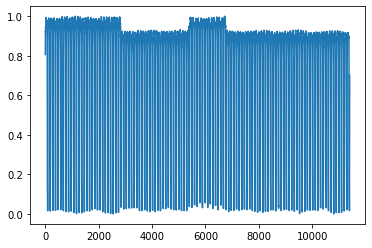

In [4]:
plt.plot(ds.ts_scaled)

In [48]:
TIME_STEPS = 220

# Generated training sequences for use in the model.
def create_sequences(values, time_steps=TIME_STEPS):
    output = []
    for i in range(len(values) - time_steps + 1):
        output.append(values[i : (i + time_steps)])
    return np.stack(output)


x_train = create_sequences(ds.ts_scaled[:int(len(ds.ts)*0.5)], TIME_STEPS)
print("Training input shape: ", x_train.shape)

Training input shape:  (5484, 220, 1)


In [25]:
dt = WindowGenerator(input_width=220, label_width=0, shift=1, train_df=ds.df.loc[:3500], val_df=ds.df.loc[3500:4500], test_df=ds.df.loc[4500:5500], label_columns='is_anomaly')

In [26]:
dt.train

ValueError: X has 2 features, but MinMaxScaler is expecting 1 features as input.

In [24]:
#
# Build and compile the model
#
tcn_ae = TCNAE(latent_sample_rate = 2) # Use the parameters specified in the paper

#
# Train TCN-AE for 10 epochs. For a better accuracy 
# on the test case, increase the epochs to epochs=40 
# The training takes about 3-4 minutes for 10 epochs, 
# and 15 minutes for 40 epochs (on Google CoLab, with GPU enabled)
#
tcn_ae.fit(dt.train, dt.train, batch_size=32, epochs=10, verbose=1, validation_split = dt.train)

/usr/local/lib/python3.9/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


TypeError: fit() got an unexpected keyword argument 'validation_split'

In [50]:
start_time = time.time()
anomaly_score = tcn_ae.predict(ds.ts_scaled[numpy.newaxis,:,:])
print("> Time:", round(time.time() - start_time), "seconds.")

> Time: 2 seconds.


In [51]:
anomaly_score

array([14.46402423, 14.69379354, 14.91170009, ..., 17.30168008,
       17.04429468, 16.80731591])

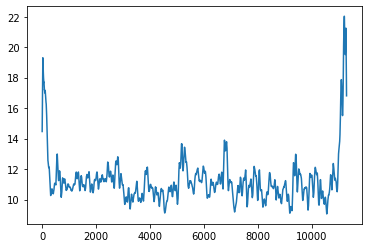

In [52]:
plt.plot(anomaly_score)

In [53]:
anomaly_score.min()

9.055744439441039

In [54]:
anomaly_score.max()

22.029391959127967

In [55]:
ds.df['is_anomaly']

0        0
1        0
2        0
3        0
4        0
        ..
11401    0
11402    0
11403    0
11404    0
11405    0
Name: is_anomaly, Length: 11406, dtype: int64

In [56]:
anomaly_score

array([14.46402423, 14.69379354, 14.91170009, ..., 17.30168008,
       17.04429468, 16.80731591])

In [1]:
plt.plot(ds.df)
plt.plot(anomaly_score/10)

NameError: name 'plt' is not defined

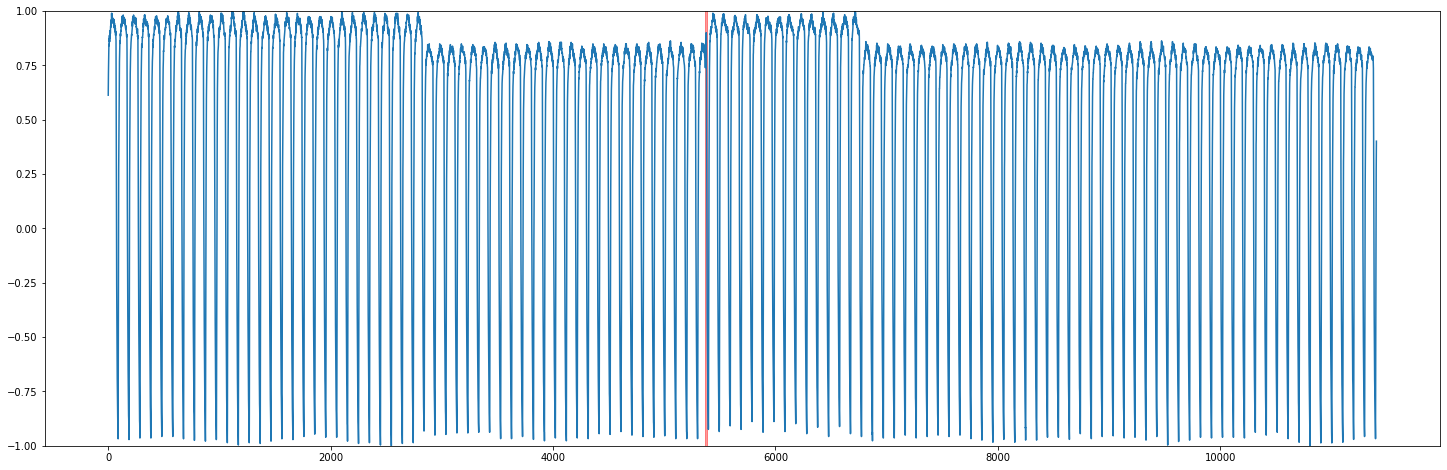

In [47]:
ds.plot()